In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate

# Import your Experiment class and related entities
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment

In [2]:
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
FRAME_RATE = 30

In [3]:
def load_experiments(data_folder):
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            file_path = os.path.join(data_folder, file)
            with open(file_path, 'rb') as f:
                exp = pickle.load(f)
                experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments

Grouping by Genotype

In [4]:
def get_sapap_genotype(genotype_string):
    if "Sapap(" in genotype_string:
        start_index = genotype_string.find("Sapap(") + len("Sapap(")
        end_index = genotype_string.find(")", start_index)
        return genotype_string[start_index:end_index]
    return None

def group_experiments_by_genotype(experiments):
    group_WT, group_KO = [], []
    for exp in experiments:
        genotype = get_sapap_genotype(exp.Genotype)
        if genotype == "WT":
            group_WT.append(exp)
        elif genotype == "KO":
            group_KO.append(exp)
        else:
            print(f"Warning: Unknown or missing Sapap genotype for Mouse {exp.Mouse_id}")
    print(f"Number of WT mice: {len(group_WT)}")
    print(f"Number of KO mice: {len(group_KO)}")
    return group_WT, group_KO


Pre-Bout Analysis (Start-of-Bout Aligned)

In [5]:
def detect_medium_bouts(experiments, min_bout_sec, max_bout_sec):
    min_frame = FRAME_RATE * min_bout_sec
    max_frame = FRAME_RATE * max_bout_sec
    group_valid_count = 0
    mouse_valid_bouts = {}
    for exp in experiments:
        annotations = exp.Grooming_annotations
        if not annotations:
            print(f"No grooming annotations for Mouse {exp.Mouse_id}")
            continue
        valid = [(start, end) for start, end in annotations if min_frame <= (end - start) <= max_frame]
        mouse_valid_bouts[exp.Mouse_id] = valid
        group_valid_count += len(valid)
    print(f"Total valid bouts ({min_bout_sec} to {max_bout_sec} sec): {group_valid_count}")
    return group_valid_count, mouse_valid_bouts

def filter_medium_bouts_by_pre_bout_activity(experiments, valid_bouts_dict, pre_bout_sec):
    pre_bout_frames = pre_bout_sec * FRAME_RATE
    filtered_bouts = {}
    filtered_traces = {}
    for exp in experiments:
        annotations = exp.Grooming_annotations
        if not annotations:
            print(f"No grooming annotations for Mouse {exp.Mouse_id}")
            continue
        valid_bouts = valid_bouts_dict.get(exp.Mouse_id, [])
        bouts_filtered = []
        traces_filtered = []
        for (start, end) in valid_bouts:
            # Exclude bouts preceded by any grooming within the pre-bout window
            has_pre = any(other_end > (start - pre_bout_frames) and other_end <= start
                          for s, other_end in annotations if (s, other_end) != (start, end))
            if not has_pre:
                bouts_filtered.append((start, end))
                ext_start = max(0, start - pre_bout_frames)
                trace, time_sec = exp.get_gcamp_data_Z_score(ext_start, end)
                traces_filtered.append((trace, time_sec))
        filtered_bouts[exp.Mouse_id] = bouts_filtered
        filtered_traces[exp.Mouse_id] = traces_filtered
    print("Filtered bouts by pre-bout activity:")
    for mouse_id, bouts in filtered_bouts.items():
        print(f"  Mouse {mouse_id}: {len(bouts)} bouts")
    return filtered_bouts, filtered_traces

def align_medium_traces(filtered_traces, filtered_bouts):
    """Aligns medium bout traces so that the bout start (in seconds) is time zero."""
    aligned = {}
    for mouse_id, traces in filtered_traces.items():
        aligned_traces = []
        for (trace, time_sec), (start, end) in zip(traces, filtered_bouts.get(mouse_id, [])):
            bout_start_time = start / FRAME_RATE
            aligned_time = time_sec - bout_start_time
            aligned_traces.append((trace, aligned_time))
        aligned[mouse_id] = aligned_traces
    return aligned

def compute_avg_medium_traces(aligned_traces, common_time):
    mouse_avg = {}
    group_traces = []
    mouse_bout_counts = {}
    for mouse_id, traces in aligned_traces.items():
        if not traces:
            print(f"Warning: No traces for Mouse {mouse_id}")
            continue
        interp_traces = [np.interp(common_time, t, trace) for trace, t in traces]
        interp_arr = np.array(interp_traces)
        avg_trace = np.mean(interp_arr, axis=0)
        std_trace = np.std(interp_arr, axis=0)
        sem_trace = std_trace / np.sqrt(len(interp_traces))
        mouse_avg[mouse_id] = {"avg_trace": avg_trace, "std_trace": std_trace, "sem_trace": sem_trace}
        mouse_bout_counts[mouse_id] = len(interp_traces)
        group_traces.extend(interp_traces)
    group_arr = np.array(group_traces)
    if group_arr.size > 0:
        group_avg = np.mean(group_arr, axis=0)
        group_std = np.std(group_arr, axis=0)
        group_sem = group_std / np.sqrt(group_arr.shape[0])
    else:
        group_avg = group_std = group_sem = None
    return mouse_avg, mouse_bout_counts, group_avg, group_std, group_sem

def plot_medium_traces(common_time, mouse_avg, mouse_bout_counts, group_avg, group_sem, group_name, color, show_individual=True, y_limits=None):
    """
    Plots the group average trace for start-of-bout analysis.
    If show_individual=True, it also plots the individual mouse traces in gray.
    Optionally, set y_limits as a tuple (ymin, ymax) to manually adjust the y-axis.
    """
    plt.figure(figsize=(14, 6))
    if show_individual:
        for mouse_id, data in mouse_avg.items():
            plt.plot(common_time, data["avg_trace"], color='gray', alpha=0.6, linewidth=1.5,
                     label=f"Mouse {mouse_id} (n={mouse_bout_counts.get(mouse_id, 0)} bouts)")
    if not show_individual:
        total_bouts = sum(mouse_bout_counts.values())
        label_str = f"{group_name} Group Average (N={len(mouse_avg)} mice)"
    else:
        label_str = f"{group_name} Group Average (n={len(mouse_avg)} mice)"
    plt.plot(common_time, group_avg, color=color, linewidth=2, label=label_str)
    plt.fill_between(common_time, group_avg - group_sem, group_avg + group_sem, color=color, alpha=0.2)
    plt.axvline(0, color='k', linestyle='--', label='Bout Start')
    plt.xlabel("Time (seconds)", fontsize=20)
    plt.ylabel("GCaMP ΔF (Z-score)", fontsize=20)
    plt.title("GCaMP Trace (Average + SEM)", fontsize=24)
    if y_limits is not None:
        plt.ylim(y_limits)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def plot_combined_medium_traces(common_time, wt_group_avg, wt_group_sem, ko_group_avg, ko_group_sem, wt_total_bouts, ko_total_bouts, y_limits=None):
    """
    Plots the group average GCaMP traces (with SEM shading) for both WT and KO groups together.
    Only the combined averages (no individual traces) are shown.
    """
    plt.figure(figsize=(14, 6))
    
    # Plot WT group average trace with SEM shading
    plt.plot(common_time, wt_group_avg, color='blue', linewidth=2, label=f"WT Group Average (n={wt_total_bouts} bouts)")
    plt.fill_between(common_time, wt_group_avg - wt_group_sem, wt_group_avg + wt_group_sem, color='blue', alpha=0.2)
    
    # Plot KO group average trace with SEM shading
    plt.plot(common_time, ko_group_avg, color='red', linewidth=2, label=f"KO Group Average (n={ko_total_bouts} bouts)")
    plt.fill_between(common_time, ko_group_avg - ko_group_sem, ko_group_avg + ko_group_sem, color='red', alpha=0.2)
    
    plt.axvline(0, color='k', linestyle='--', label='Bout Start')
    plt.xlabel("Time (seconds)", fontsize=20)
    plt.ylabel("GCaMP ΔF (Z-score)", fontsize=20)
    plt.title("GCaMP Trace (Average + SEM)", fontsize=24)
    
    if y_limits is not None:
        plt.ylim(y_limits)
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def plot_combined_postbout_traces(common_time, wt_group_avg, wt_group_sem, ko_group_avg, ko_group_sem, wt_total_bouts, ko_total_bouts, y_limits=None):
    """
    Plots the group average post-bout GCaMP traces (with SEM shading) for both WT and KO groups together.
    The x-axis represents time relative to the bout end (time 0).
    """
    plt.figure(figsize=(14, 6))
    
    # Plot WT group average trace with SEM shading
    plt.plot(common_time, wt_group_avg, color='blue', linewidth=2, label=f"WT Group Average (n={wt_total_bouts} bouts)")
    plt.fill_between(common_time, wt_group_avg - wt_group_sem, wt_group_avg + wt_group_sem, color='blue', alpha=0.2)
    
    # Plot KO group average trace with SEM shading
    plt.plot(common_time, ko_group_avg, color='red', linewidth=2, label=f"KO Group Average (n={ko_total_bouts} bouts)")
    plt.fill_between(common_time, ko_group_avg - ko_group_sem, ko_group_avg + ko_group_sem, color='red', alpha=0.2)
    
    # Bout end line at time zero
    plt.axvline(0, color='k', linestyle='--', label='Bout End (Time 0)')
    
    plt.xlabel("Time Relative to Bout End (seconds)", fontsize=20)
    plt.ylabel("GCaMP ΔF/F (Z-score)", fontsize=20)
    plt.title("Combined Post-Bout GCaMP Trace (Average + SEM)", fontsize=24)
    
    if y_limits is not None:
        plt.ylim(y_limits)
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


POST-BOUT ANALYSIS (Aligned to Bout End)

In [6]:
def detect_postbout_valid_bouts(experiments, min_bout_sec, post_bout_sec):
    """
    Detects bouts that are at least min_bout_sec long and have a post-bout window
    (of length post_bout_sec) free of grooming.
    Returns (group_valid_count, mouse_valid_bouts)
    """
    min_frame_length = FRAME_RATE * min_bout_sec
    post_bout_frame_length = FRAME_RATE * post_bout_sec
    group_valid_count = 0
    mouse_valid_bouts = {}
    for exp in experiments:
        annotations = exp.Grooming_annotations
        if not annotations:
            print(f"No grooming annotations for Mouse {exp.Mouse_id}")
            continue
        valid_bouts = []
        for (start, end) in annotations:
            if (end - start) < min_frame_length:
                continue
            post_bout_start = end
            post_bout_end = end + post_bout_frame_length
            grooming_in_post_window = any(
                other_start < post_bout_end and other_start >= post_bout_start
                for other_start, other_end in annotations
            )
            if not grooming_in_post_window:
                valid_bouts.append((start, end))
        mouse_valid_bouts[exp.Mouse_id] = valid_bouts
        group_valid_count += len(valid_bouts)
    print(f"\nPost-Bout Analysis: Total valid bouts (>= {min_bout_sec}s and no grooming in next {post_bout_sec}s): {group_valid_count}")
    return group_valid_count, mouse_valid_bouts

def process_postbout_gcamp_z_score(valid_bouts_dict, experiment_dict, min_bout_sec, post_bout_sec):
    """
    Extracts GCaMP Z-score traces for bouts (from bout start to end plus post_bout_sec)
    and excludes bouts if the extracted trace is too short.
    Returns a dictionary {mouse_id: [(trace, time_sec), ...]}.
    """
    gcamp_data_dict = {}
    total_traces = 0
    for mouse_id, bouts in valid_bouts_dict.items():
        mouse_data = []
        for (start, end) in bouts:
            expected_frames = FRAME_RATE * (min_bout_sec + post_bout_sec)
            exp = experiment_dict.get(mouse_id)
            if exp is None:
                continue
            trace, time_sec = exp.get_gcamp_data_Z_score(start, end, extra_time_before=0, extra_time_after=post_bout_sec)
            if len(time_sec) < expected_frames:
                print(f"Excluding bout from Mouse {mouse_id}: Trace too short ({len(time_sec)/FRAME_RATE:.2f} sec instead of {(expected_frames)/FRAME_RATE:.2f} sec)")
                continue
            mouse_data.append((trace, time_sec))
            total_traces += 1
        gcamp_data_dict[mouse_id] = mouse_data
    print(f"Processed post-bout GCaMP data: {total_traces} traces extracted.")
    return gcamp_data_dict

def align_postbout_traces(valid_bouts_dict, postbout_gcamp_data_dict):
    """
    Aligns post-bout traces so that the end of the bout is at time zero.
    (Subtracts [initial time + bout duration] from the time vector.)
    Returns {mouse_id: [(aligned_time, trace), ...]}.
    """
    aligned = {}
    for mouse_id, traces in postbout_gcamp_data_dict.items():
        mouse_data = []
        bouts = valid_bouts_dict.get(mouse_id, [])
        for (trace, time_sec), (start, end) in zip(traces, bouts):
            bout_duration = (end - start) / FRAME_RATE  # in seconds
            aligned_time = time_sec - (time_sec[0] + bout_duration)
            mouse_data.append((aligned_time, trace))
        aligned[mouse_id] = mouse_data
    print("Post-bout traces aligned (bout end at time zero).")
    return aligned

def compute_avg_postbout_trace_per_mouse(aligned_traces):
    """
    Computes an average trace per mouse from post-bout aligned traces.
    Returns a dictionary {mouse_id: avg_trace}.
    """
    avg_traces = {}
    for mouse_id, traces in aligned_traces.items():
        if not traces:
            continue
        min_length = min(len(aligned_time) for aligned_time, trace in traces)
        trimmed_traces = [trace[:min_length] for aligned_time, trace in traces]
        avg_trace = np.mean(trimmed_traces, axis=0)
        avg_traces[mouse_id] = avg_trace
    return avg_traces

def compute_group_avg_postbout_trace(mouse_avg_traces):
    all_traces = list(mouse_avg_traces.values())
    min_length = min(len(trace) for trace in all_traces)
    trimmed_traces = np.array([trace[:min_length] for trace in all_traces])
    group_avg = np.mean(trimmed_traces, axis=0)
    group_std = np.std(trimmed_traces, axis=0)
    group_sem = group_std / np.sqrt(len(trimmed_traces))
    return group_avg, group_std, group_sem

def plot_postbout_traces(mouse_avg_traces, group_avg_trace, group_sem_trace, group_valid_bouts_count,
                         min_bout_sec, post_bout_sec, group_name, color, show_individual=True, y_limits=None):
    """
    Plots the post-bout aligned traces with time 0 at bout end.
    If show_individual=True, it also plots each individual mouse’s trace in gray.
    Optionally, set y_limits as a tuple (ymin, ymax) to manually adjust the y-axis.
    """
    min_length = min(len(trace) for trace in mouse_avg_traces.values())
    avg_time = np.linspace(-min_bout_sec, post_bout_sec, min_length)
    plt.figure(figsize=(14,6))
    if show_individual:
        for mouse_id, trace in mouse_avg_traces.items():
            interp_trace = np.interp(avg_time, np.linspace(-min_bout_sec, post_bout_sec, len(trace)), trace)
            plt.plot(avg_time, interp_trace, color='gray', alpha=0.5, linewidth=1)
    if not show_individual:
        N = len(mouse_avg_traces)
        label_str = f"{group_name} Group Average (N={N} mice, n={group_valid_bouts_count} bouts)"
    else:
        label_str = f"{group_name} Group Average (n={group_valid_bouts_count} bouts)"
    plt.plot(avg_time, group_avg_trace, color=color, linewidth=2, label=label_str)
    plt.fill_between(avg_time, group_avg_trace - group_sem_trace, group_avg_trace + group_sem_trace,
                     color=color, alpha=0.3, label="SEM")
    plt.axvline(0, color='k', linestyle='--', label="Bout End (Time 0)")
    plt.xlabel("Time Relative to Bout End (seconds)")
    plt.ylabel("GCaMP ΔF/F (Z-score)")
    plt.title(f"{group_name} Group - Post-Bout Aligned GCaMP Trace")
    if y_limits is not None:
        plt.ylim(y_limits)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


SMOOTH POST-BOUT ANALYSIS FUNCTIONS

In [7]:
def detect_postbout_valid_smooth_bouts(experiments, min_bout_sec, post_bout_sec):
    """
    Detects smooth bouts that are at least min_bout_sec long and have a post-bout window 
    (of length post_bout_sec) free of grooming (based on the smooth bout annotations).
    Returns (group_valid_count, mouse_valid_bouts)
    """
    min_frame_length = FRAME_RATE * min_bout_sec
    post_bout_frame_length = FRAME_RATE * post_bout_sec
    group_valid_count = 0
    mouse_valid_bouts = {}
    for exp in experiments:
        # Assumes that smooth bouts are stored in exp.smooth_grooming_bouts
        smooth_bouts = getattr(exp, 'smooth_grooming_bouts', None)
        if not smooth_bouts:
            print(f"No smooth grooming bouts for Mouse {exp.Mouse_id}")
            continue
        valid_bouts = []
        for (start, end) in smooth_bouts:
            if (end - start) < min_frame_length:
                continue
            post_bout_start = end
            post_bout_end = end + post_bout_frame_length
            # Check within the smooth bout annotations for any grooming occurring in the post-window
            grooming_in_post_window = any(
                other_start < post_bout_end and other_start >= post_bout_start
                for other_start, other_end in smooth_bouts
            )
            if not grooming_in_post_window:
                valid_bouts.append((start, end))
        mouse_valid_bouts[exp.Mouse_id] = valid_bouts
        group_valid_count += len(valid_bouts)
    print(f"\nSmooth Post-Bout Analysis: Total valid bouts (>= {min_bout_sec}s and no grooming in next {post_bout_sec}s): {group_valid_count}")
    return group_valid_count, mouse_valid_bouts


def process_postbout_gcamp_z_score_smooth(valid_bouts_dict, experiment_dict, min_bout_sec, post_bout_sec):
    """
    Extracts GCaMP Z-score traces for smooth bouts (from bout start to bout end plus post_bout_sec).
    Here we assume that the experiment object has a method (or you use get_gcamp_data_Z_score)
    that works appropriately with smooth bouts.
    Returns a dictionary {mouse_id: [(trace, time_sec), ...]}.
    """
    gcamp_data_dict = {}
    total_traces = 0
    for mouse_id, bouts in valid_bouts_dict.items():
        mouse_data = []
        for (start, end) in bouts:
            expected_frames = FRAME_RATE * (min_bout_sec + post_bout_sec)
            exp = experiment_dict.get(mouse_id)
            if exp is None:
                continue
            # You might need a dedicated method for smooth bouts.
            # For illustration, we assume get_gcamp_data_Z_score can be used.
            trace, time_sec = exp.get_gcamp_data_Z_score(start, end, extra_time_before=0, extra_time_after=post_bout_sec)
            if len(time_sec) < expected_frames:
                print(f"Excluding smooth bout from Mouse {mouse_id}: Trace too short ({len(time_sec)/FRAME_RATE:.2f} sec instead of {(expected_frames)/FRAME_RATE:.2f} sec)")
                continue
            mouse_data.append((trace, time_sec))
            total_traces += 1
        gcamp_data_dict[mouse_id] = mouse_data
    print(f"Processed smooth post-bout GCaMP data: {total_traces} traces extracted.")
    return gcamp_data_dict


def align_postbout_smooth_traces(valid_bouts_dict, postbout_gcamp_data_dict):
    """
    Aligns smooth post-bout traces so that the bout end is at time zero.
    Returns {mouse_id: [(aligned_time, trace), ...]}.
    """
    aligned = {}
    for mouse_id, traces in postbout_gcamp_data_dict.items():
        mouse_data = []
        bouts = valid_bouts_dict.get(mouse_id, [])
        for (trace, time_sec), (start, end) in zip(traces, bouts):
            bout_duration = (end - start) / FRAME_RATE  # in seconds
            aligned_time = time_sec - (time_sec[0] + bout_duration)
            mouse_data.append((aligned_time, trace))
        aligned[mouse_id] = mouse_data
    print("Smooth post-bout traces aligned (bout end at time zero).")
    return aligned

In [8]:

def filter_smooth_bouts_by_pre_bout_activity(experiments, pre_bout_sec):
    pre_bout_frames = pre_bout_sec * 30  # Assuming 30Hz
    filtered_bouts = {}
    for exp in experiments:
        bouts = exp.smooth_grooming_bouts or []
        valid_bouts = []
        for (start, end) in bouts:
            has_pre = any(
                other_end > (start - pre_bout_frames) and other_end <= start
                for s, other_end in bouts if (s, other_end) != (start, end)
            )
            if not has_pre:
                valid_bouts.append((start, end))
        filtered_bouts[exp.Mouse_id] = valid_bouts
    return filtered_bouts

def get_zscore_traces_from_filtered_bouts(experiment_dict, filtered_bouts, pre_bout_time):
    traces = {}
    for mouse_id, bouts in filtered_bouts.items():
        exp = experiment_dict[mouse_id]
        results = []
        for start, end in bouts:
            z, t = exp.get_gcamp_data_Z_score(start, end, extra_time_before=pre_bout_time)
            results.append((z, t))
        traces[mouse_id] = results
    return traces

def align_smooth_traces(smooth_traces_dict, pre_bout_time):
    aligned = {}
    for mouse_id, traces in smooth_traces_dict.items():
        aligned_traces = []
        for trace, time_sec in traces:
            aligned_time = time_sec - (time_sec[0] + pre_bout_time)
            aligned_traces.append((trace, aligned_time))
        aligned[mouse_id] = aligned_traces
    return aligned

def compute_avg_traces(aligned_traces, common_time):
    mouse_avg = {}
    group_traces = []
    mouse_bout_counts = {}
    for mouse_id, traces in aligned_traces.items():
        if not traces:
            print(f"Warning: No traces for Mouse {mouse_id} (smooth bouts)")
            continue
        interp_traces = [np.interp(common_time, t, trace) for trace, t in traces]
        interp_arr = np.array(interp_traces)
        avg_trace = np.mean(interp_arr, axis=0)
        std_trace = np.std(interp_arr, axis=0)
        sem_trace = std_trace / np.sqrt(len(interp_traces))
        mouse_avg[mouse_id] = {"avg_trace": avg_trace, "std_trace": std_trace, "sem_trace": sem_trace}
        mouse_bout_counts[mouse_id] = len(interp_traces)
        group_traces.extend(interp_traces)
    group_arr = np.array(group_traces)
    if group_arr.size > 0:
        group_avg = np.mean(group_arr, axis=0)
        group_std = np.std(group_arr, axis=0)
        group_sem = group_std / np.sqrt(group_arr.shape[0])
    else:
        group_avg = group_std = group_sem = None
    return mouse_avg, mouse_bout_counts, group_avg, group_std, group_sem



Main Execution

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M372_eEPA_R_adBNST.pkl
Loaded: M393_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Total .pkl files loaded: 12
Number of WT mice: 5
Number of KO mice: 7

*** Raw Grooming Bouts Analysis ***
Total valid bouts (2.5 to 300 sec): 130
Total valid bouts (2.5 to 300 sec): 219
Filtered bouts by pre-bout activity:
  Mouse M329: 9 bouts
  Mouse M344: 10 bouts
  Mouse M354: 22 bouts
  Mouse M365: 5 bouts
  Mouse M372: 7 bouts
Filtered bouts by pre-bout activity:
  Mouse M338: 6 bouts
  Mouse M352: 16 bouts
  Mouse M393: 8 bouts
  Mouse M406: 13 bouts
  Mouse M407: 20 bouts
  Mouse M416: 12 bouts
  Mouse M420: 8 bouts


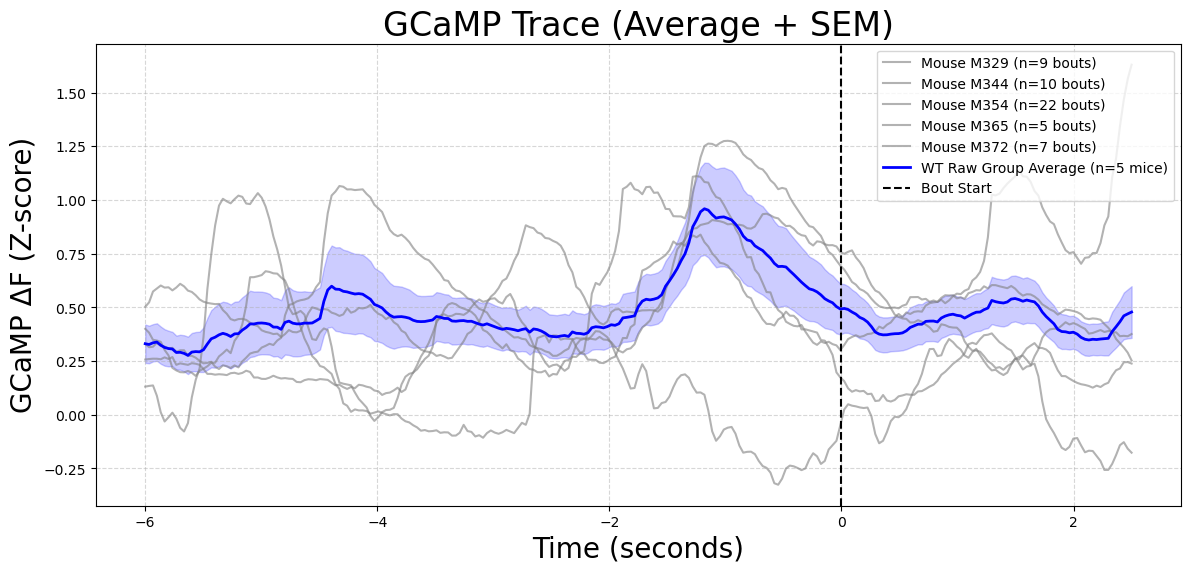

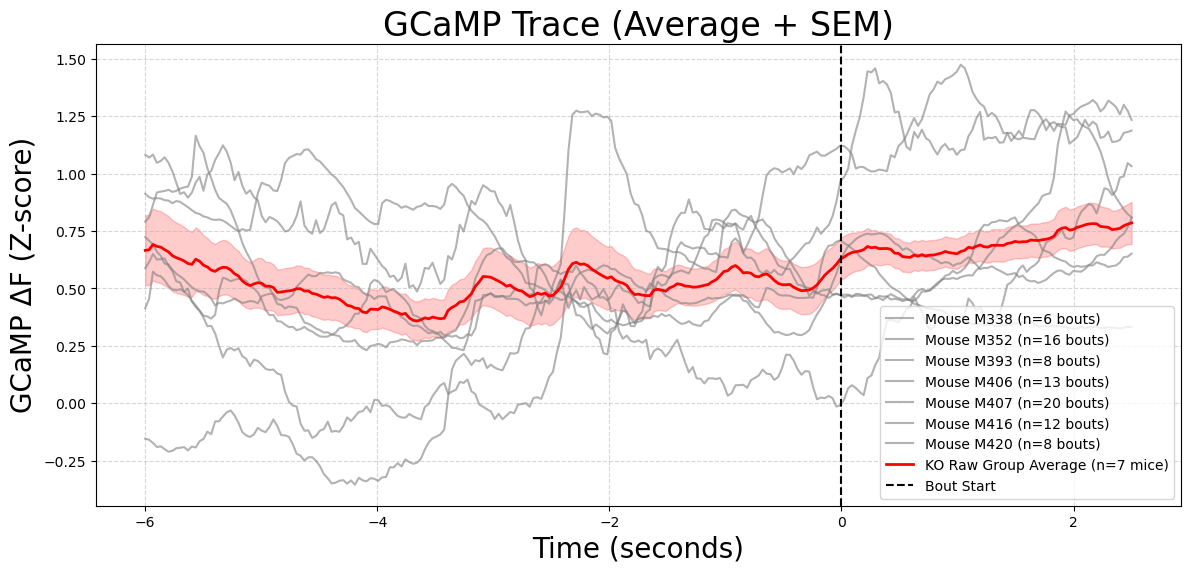

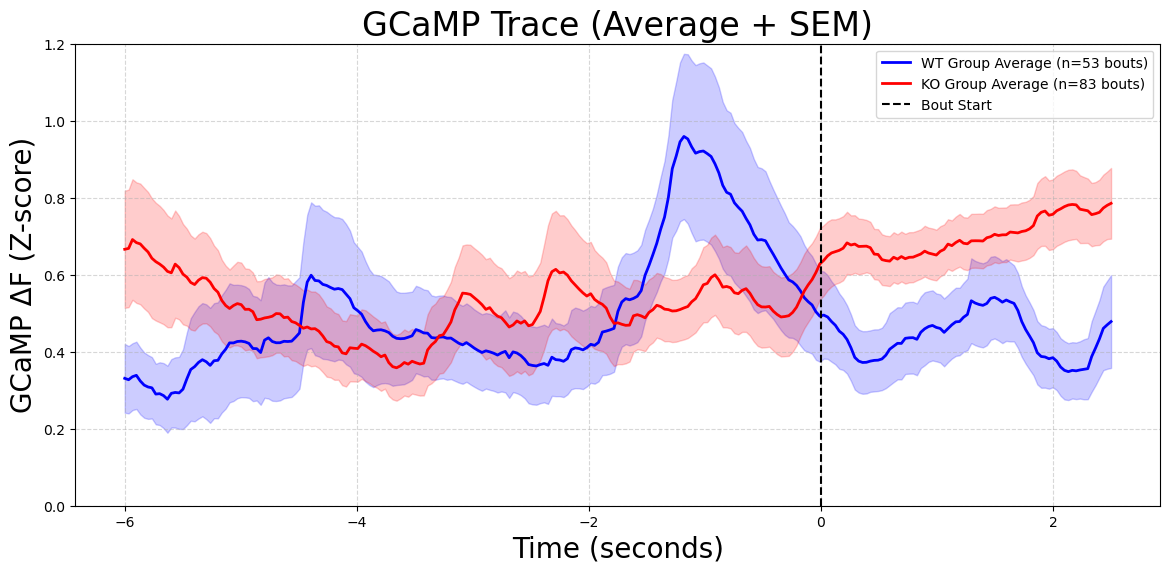


*** Smooth Grooming Bouts Analysis ***


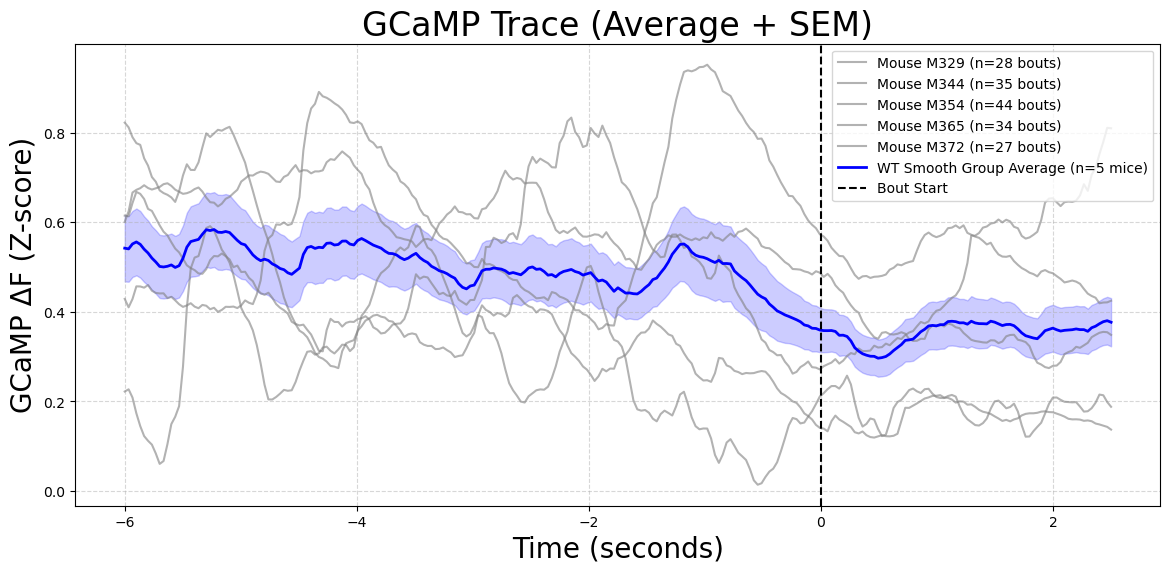

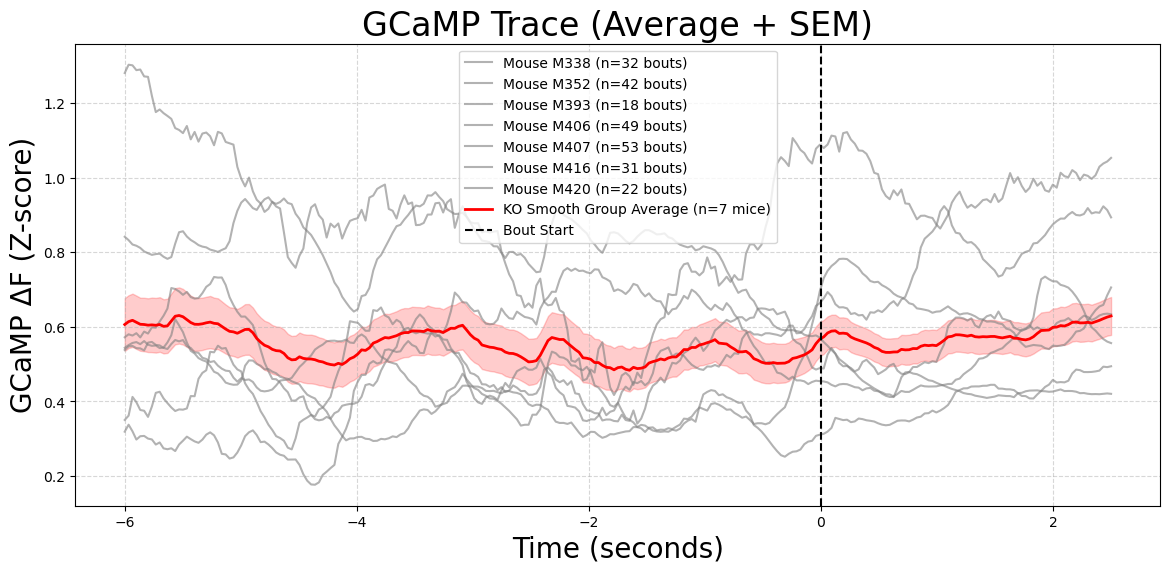

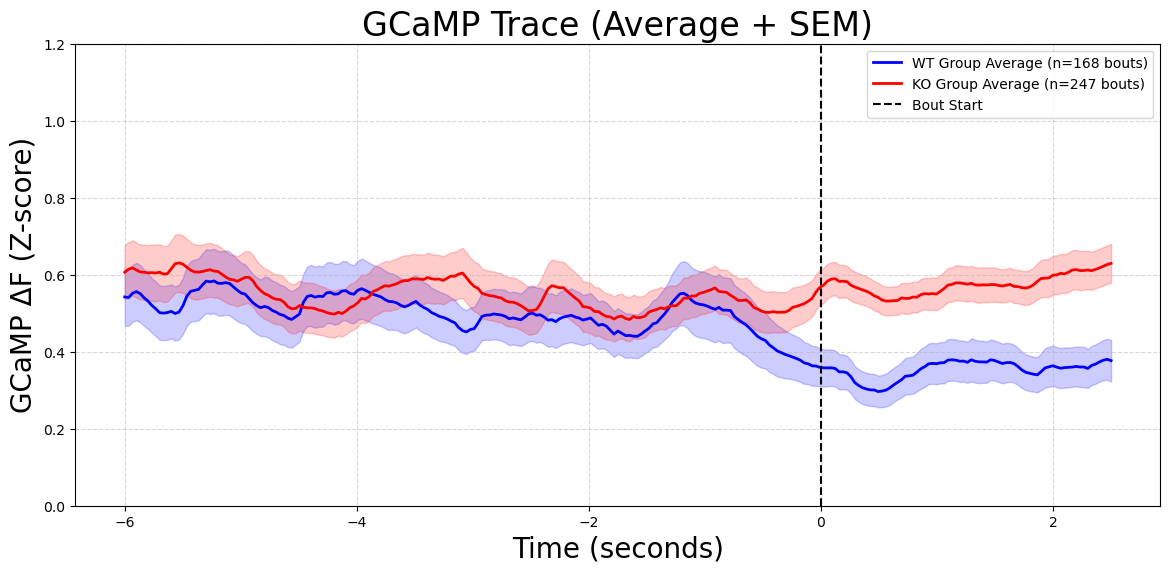

In [9]:
if __name__ == '__main__':
    # Load experiments
    experiments = load_experiments(DATA_FOLDER)
    for exp in experiments:
        exp.smooth_grooming_bouts_generator(threshold=60)
    
    group_WT, group_KO = group_experiments_by_genotype(experiments)
    experiment_dict = {exp.Mouse_id: exp for exp in experiments}

    # Parameters
    MINIMUM_BOUT_LENGTH = 2.5
    MAXIMUM_BOUT_LENGTH = 300
    PRE_BOUT_TIME = 6

    # ===== RAW BOUT ANALYSIS =====
    print("\n*** Raw Grooming Bouts Analysis ***")
    wt_raw_count, wt_raw_bouts = detect_medium_bouts(group_WT, MINIMUM_BOUT_LENGTH, MAXIMUM_BOUT_LENGTH)
    ko_raw_count, ko_raw_bouts = detect_medium_bouts(group_KO, MINIMUM_BOUT_LENGTH, MAXIMUM_BOUT_LENGTH)

    wt_raw_filtered_bouts, wt_raw_filtered_traces = filter_medium_bouts_by_pre_bout_activity(group_WT, wt_raw_bouts, PRE_BOUT_TIME)
    ko_raw_filtered_bouts, ko_raw_filtered_traces = filter_medium_bouts_by_pre_bout_activity(group_KO, ko_raw_bouts, PRE_BOUT_TIME)

    wt_raw_aligned = align_medium_traces(wt_raw_filtered_traces, wt_raw_filtered_bouts)
    ko_raw_aligned = align_medium_traces(ko_raw_filtered_traces, ko_raw_filtered_bouts)

    common_time_raw = np.linspace(-PRE_BOUT_TIME, MINIMUM_BOUT_LENGTH, int((PRE_BOUT_TIME + MINIMUM_BOUT_LENGTH) * FRAME_RATE))

    wt_raw_mouse_avg, wt_raw_counts, wt_raw_avg, _, wt_raw_sem = compute_avg_medium_traces(wt_raw_aligned, common_time_raw)
    ko_raw_mouse_avg, ko_raw_counts, ko_raw_avg, _, ko_raw_sem = compute_avg_medium_traces(ko_raw_aligned, common_time_raw)

    total_wt_raw = sum(wt_raw_counts.values())
    total_ko_raw = sum(ko_raw_counts.values())

    plot_medium_traces(common_time_raw, wt_raw_mouse_avg, wt_raw_counts, wt_raw_avg, wt_raw_sem, "WT Raw", color='blue', show_individual=True)
    plot_medium_traces(common_time_raw, ko_raw_mouse_avg, ko_raw_counts, ko_raw_avg, ko_raw_sem, "KO Raw", color='red', show_individual=True)
    plot_combined_medium_traces(common_time_raw, wt_raw_avg, wt_raw_sem, ko_raw_avg, ko_raw_sem, total_wt_raw, total_ko_raw, y_limits=(0, 1.2))

    # ===== SMOOTH BOUT ANALYSIS =====
    print("\n*** Smooth Grooming Bouts Analysis ***")
    wt_smooth_filtered = filter_smooth_bouts_by_pre_bout_activity(group_WT, PRE_BOUT_TIME)
    ko_smooth_filtered = filter_smooth_bouts_by_pre_bout_activity(group_KO, PRE_BOUT_TIME)

    wt_smooth_traces = get_zscore_traces_from_filtered_bouts(experiment_dict, wt_smooth_filtered, PRE_BOUT_TIME)
    ko_smooth_traces = get_zscore_traces_from_filtered_bouts(experiment_dict, ko_smooth_filtered, PRE_BOUT_TIME)

    wt_aligned_smooth = align_smooth_traces(wt_smooth_traces, PRE_BOUT_TIME)
    ko_aligned_smooth = align_smooth_traces(ko_smooth_traces, PRE_BOUT_TIME)

    common_time_smooth = np.linspace(-PRE_BOUT_TIME, MINIMUM_BOUT_LENGTH, int((PRE_BOUT_TIME + MINIMUM_BOUT_LENGTH) * FRAME_RATE))

    wt_smooth_mouse_avg, wt_smooth_counts, wt_smooth_avg, _, wt_smooth_sem = compute_avg_traces(wt_aligned_smooth, common_time_smooth)
    ko_smooth_mouse_avg, ko_smooth_counts, ko_smooth_avg, _, ko_smooth_sem = compute_avg_traces(ko_aligned_smooth, common_time_smooth)

    total_wt_smooth = sum(wt_smooth_counts.values())
    total_ko_smooth = sum(ko_smooth_counts.values())

    plot_medium_traces(common_time_smooth, wt_smooth_mouse_avg, wt_smooth_counts, wt_smooth_avg, wt_smooth_sem, "WT Smooth", color='blue', show_individual=True)
    plot_medium_traces(common_time_smooth, ko_smooth_mouse_avg, ko_smooth_counts, ko_smooth_avg, ko_smooth_sem, "KO Smooth", color='red', show_individual=True)
    plot_combined_medium_traces(common_time_smooth, wt_smooth_avg, wt_smooth_sem, ko_smooth_avg, ko_smooth_sem, total_wt_smooth, total_ko_smooth, y_limits=(0, 1.2))